# Importing 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn import set_config; set_config(display='diagram')
from package.etl import *
from package.train_baseline import TrainBaseline
from package.train_city import TrainCity
from package.train_store import TrainStore
from package.train_family import TrainFamily
import pandas as pd
import numpy as np
import requests
import joblib
import json
from fbprophet import Prophet
import matplotlib.pyplot as plt

/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Creating the Preprocessing

In [3]:
df_sales = pd.read_csv("gs://business-case/train.csv")

In [4]:
df_sales

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [5]:
df_stores = pd.read_csv("gs://business-case/stores.csv")

In [6]:
df_stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [7]:
sales_and_stores = pd.merge(df_sales, df_stores, on='store_nbr')

In [8]:
sales_and_stores

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6


# Putting our DataFrame in the FBProphet format

In [9]:
sales_and_stores = sales_and_stores.reset_index().rename(columns={'date': 'ds', 'sales':'y'}).drop(columns=["type", "cluster", "index", "id", "state"])
sales_and_stores.head()

,ds,store_nbr,family,y,onpromotion,city
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito
1,2013-01-01,1,BABY CARE,0.0,0,Quito
2,2013-01-01,1,BEAUTY,0.0,0,Quito
3,2013-01-01,1,BEVERAGES,0.0,0,Quito
4,2013-01-01,1,BOOKS,0.0,0,Quito


In [10]:
# sales_and_stores['date'] = pd.to_datetime(sales_and_stores['date'])         # Changing the column date to DateTime
 

## criar uma função com todos os itens abaixo para implementar o for loop

In [11]:
# previsões por familia
# achar o percentual total de vendas para cada loja
# dividir esse percentual por previsão

# criar a função do prophet
# criar a função por divisão

In [12]:
tmp_df_prep = sales_and_stores[sales_and_stores['family']== 'BEVERAGES']
tmp_df_prep

,ds,store_nbr,family,y,onpromotion,city
3,2013-01-01,1,BEVERAGES,0.0,0,Quito
36,2013-01-02,1,BEVERAGES,1091.0,0,Quito
69,2013-01-03,1,BEVERAGES,919.0,0,Quito
102,2013-01-04,1,BEVERAGES,953.0,0,Quito
135,2013-01-05,1,BEVERAGES,1160.0,0,Quito
...,...,...,...,...,...,...
3000726,2017-08-11,9,BEVERAGES,2619.0,25,Quito
3000759,2017-08-12,9,BEVERAGES,3374.0,27,Quito
3000792,2017-08-13,9,BEVERAGES,3752.0,31,Quito
3000825,2017-08-14,9,BEVERAGES,3367.0,28,Quito


In [13]:
tmp_df_prep['ds'] = pd.to_datetime(tmp_df_prep['ds'])

/tmp/ipykernel_19046/869872489.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df_prep['ds'] = pd.to_datetime(tmp_df_prep['ds'])


In [14]:
tmp_df = tmp_df_prep.groupby(by='ds').sum().drop(columns=["store_nbr", "onpromotion"]).reset_index()
tmp_df

,ds,y
0,2013-01-01,810.0
1,2013-01-02,72092.0
2,2013-01-03,52105.0
3,2013-01-04,54167.0
4,2013-01-05,77818.0
...,...,...
1679,2017-08-11,189111.0
1680,2017-08-12,182318.0
1681,2017-08-13,202354.0
1682,2017-08-14,174832.0


In [15]:
tmp_df.iloc[:1457]

,ds,y
0,2013-01-01,810.0
1,2013-01-02,72092.0
2,2013-01-03,52105.0
3,2013-01-04,54167.0
4,2013-01-05,77818.0
...,...,...
1452,2016-12-27,177554.0
1453,2016-12-28,192477.0
1454,2016-12-29,186177.0
1455,2016-12-30,240693.0


In [16]:
train = tmp_df.iloc[:1457]
test = tmp_df.iloc[1458:]

model = Prophet(seasonality_mode='multiplicative')

model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -21.526
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2709.97    0.00233284       114.287      0.4181      0.4181      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       2713.99   0.000402172       134.717   3.302e-06       0.001      263  LS failed, Hessian reset 
     199       2714.49   0.000535302       63.9407           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2714.75   0.000684672       91.7522      0.4979      0.4979      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       2715.27   0.000347309       131.322    2.61e-06       0.001      480  LS failed, Hessian reset 
     346        2715.6   0.000148054       64.3663   2.375e-06       0.001      567  LS failed, Hessian reset

     61.1855   5.195e-08       0.001      643  LS failed, Hessian reset 
     389       2715.61   2.31961e-07        47.107      0.1327           1      659   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [17]:
forecast_test = model.predict(test)
forecast_test.head()

/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-01-02,163528.972055,150144.618849,217174.187190,163528.972055,163528.972055,0.126817,0.126817,0.126817,-0.041257,-0.041257,-0.041257,0.168074,0.168074,0.168074,0.0,0.0,0.0,184267.177262
1,2017-01-03,163501.378101,130162.458887,205896.252312,163501.378101,163501.378101,0.021295,0.021295,0.021295,-0.133428,-0.133428,-0.133428,0.154724,0.154724,0.154724,0.0,0.0,0.0,166983.214624
2,2017-01-04,163473.784148,129712.238114,200950.644498,163473.784148,163473.784148,0.011222,0.011222,0.011222,-0.129548,-0.129548,-0.129548,0.140770,0.140770,0.140770,0.0,0.0,0.0,165308.296463
3,2017-01-05,163446.190194,110197.112696,182896.691861,163446.190194,163446.190194,-0.103097,-0.103097,-0.103097,-0.229494,-0.229494,-0.229494,0.126398,0.126398,0.126398,0.0,0.0,0.0,146595.450730
4,2017-01-06,163418.596241,128045.480319,198888.281650,163418.596241,163418.596241,-0.000270,-0.000270,-0.000270,-0.112064,-0.112064,-0.112064,0.111795,0.111795,0.111795,0.0,0.0,0.0,163374.551773


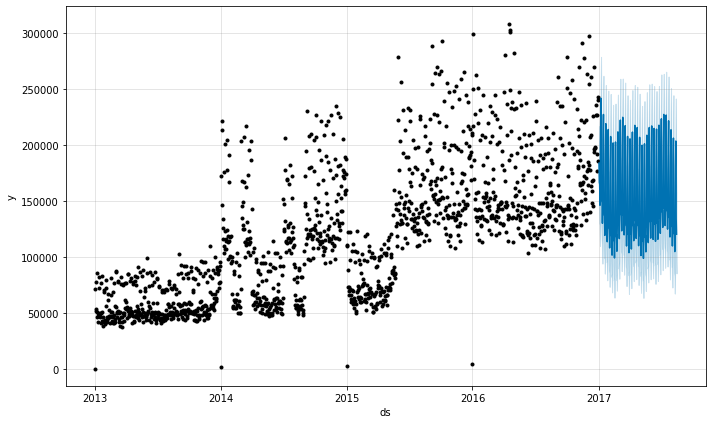

In [18]:
# Build-it plot
model.plot(forecast_test);

In [19]:
future = model.make_future_dataframe(periods=12, freq='MS')
forecast_future = model.predict(future)
forecast_future.head()

/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2013-01-01,52436.248694,21637.516623,92109.120528,52436.248694,52436.248694,0.047210,0.047210,0.047210,-0.133428,-0.133428,-0.133428,0.180638,0.180638,0.180638,0.0,0.0,0.0,54911.769776
1,2013-01-02,52494.441074,19913.593104,91039.251368,52494.441074,52494.441074,0.038526,0.038526,0.038526,-0.129548,-0.129548,-0.129548,0.168074,0.168074,0.168074,0.0,0.0,0.0,54516.853049
2,2013-01-03,52552.633455,12255.187269,85332.526251,52552.633455,52552.633455,-0.074771,-0.074771,-0.074771,-0.229494,-0.229494,-0.229494,0.154724,0.154724,0.154724,0.0,0.0,0.0,48623.242032
3,2013-01-04,52610.825836,17013.289097,90451.351476,52610.825836,52610.825836,0.028705,0.028705,0.028705,-0.112064,-0.112064,-0.112064,0.140770,0.140770,0.140770,0.0,0.0,0.0,54121.029054
4,2013-01-05,52669.018216,37107.146788,110875.853818,52669.018216,52669.018216,0.372655,0.372655,0.372655,0.246257,0.246257,0.246257,0.126398,0.126398,0.126398,0.0,0.0,0.0,72296.371140


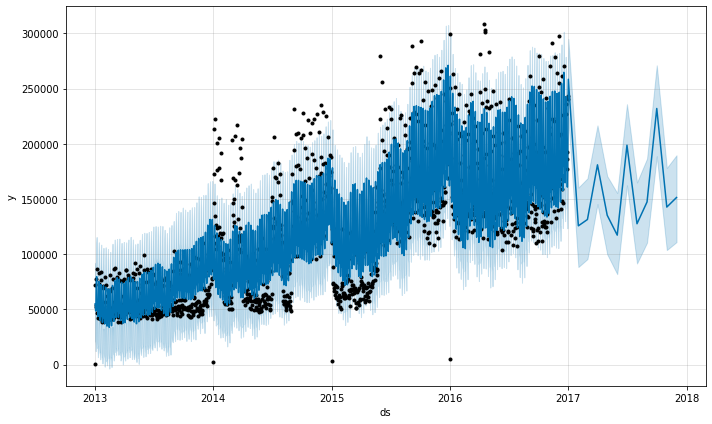

In [20]:
# Build-it plot
model.plot(forecast_future);

In [21]:
# não colocar na função

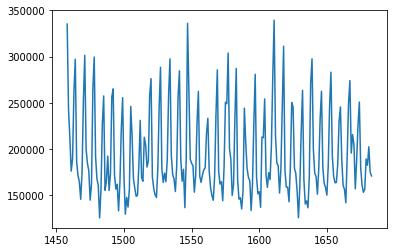

In [22]:
test.set_index('ds')['y'] 
plt.plot(test['y'])

In [23]:
# não colocar na função

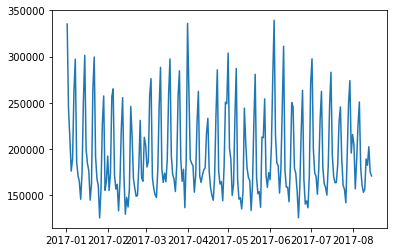

In [24]:
plt.plot(test.set_index('ds')['y'])

/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


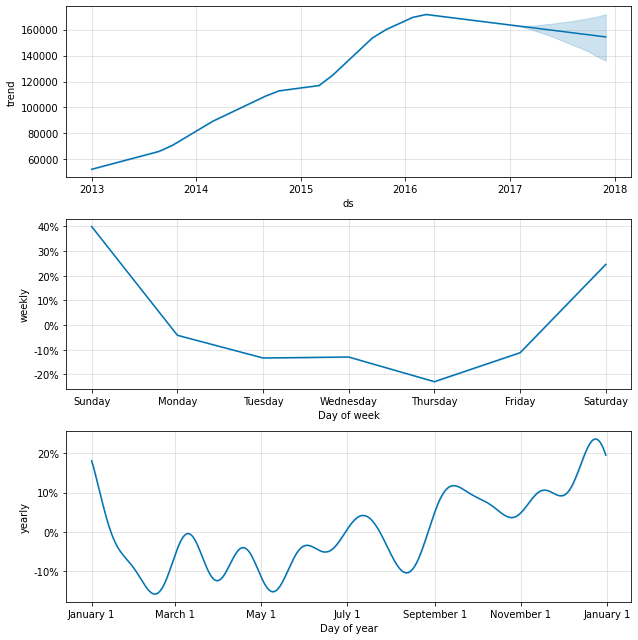

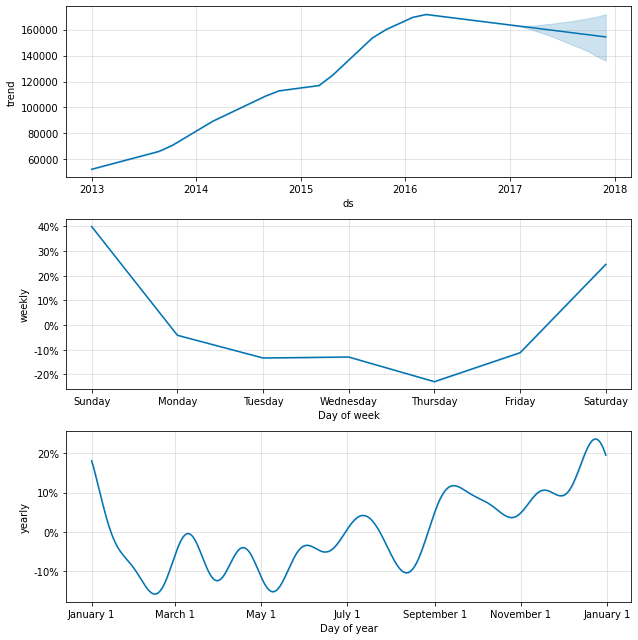

In [25]:
model.plot_components(fcst=forecast_future)

## Predictions per month

In [26]:
tmp_df_prep['year'] = tmp_df_prep['ds'].dt.year
tmp_df_prep['month'] = tmp_df_prep['ds'].dt.month
tmp_df_prep['week'] = tmp_df_prep['ds'].dt.week

/tmp/ipykernel_19046/1841313538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df_prep['year'] = tmp_df_prep['ds'].dt.year
/tmp/ipykernel_19046/1841313538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df_prep['month'] = tmp_df_prep['ds'].dt.month
/tmp/ipykernel_19046/1841313538.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  tmp_df_prep['week'] = tmp_df_prep['ds'].dt.week
/tmp/ipykernel_19046/1841313538.

In [27]:
tmp_df_week = tmp_df_prep.groupby(['year', 'month', 'week', 'store_nbr']).sum().reset_index()

In [28]:
tmp_df_week

,year,month,week,store_nbr,y,onpromotion
0,2013,1,1,1,4530.0,0
1,2013,1,1,2,7124.0,0
2,2013,1,1,3,21496.0,0
3,2013,1,1,4,6929.0,0
4,2013,1,1,5,4689.0,0
...,...,...,...,...,...,...
15601,2017,8,33,50,7575.0,26
15602,2017,8,33,51,7748.0,24
15603,2017,8,33,52,7664.0,24
15604,2017,8,33,53,3270.0,22


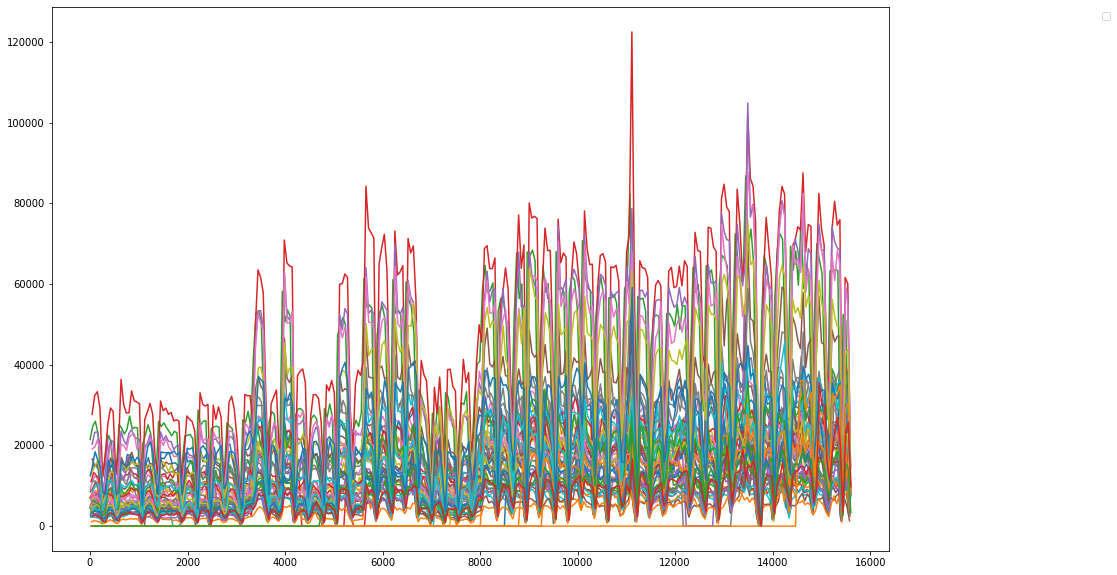

In [41]:
plt.figure(figsize=(15,10))
for store in tmp_df_week['store_nbr'].unique():
    plt.plot(tmp_df_week[tmp_df_week['store_nbr']== store]['y'])
    
plt.legend(loc='upper right', bbox_to_anchor=(1.27, 1))

In [30]:
tmp_df_week.iloc[:13446]

,year,month,week,store_nbr,y,onpromotion
0,2013,1,1,1,4530.0,0
1,2013,1,1,2,7124.0,0
2,2013,1,1,3,21496.0,0
3,2013,1,1,4,6929.0,0
4,2013,1,1,5,4689.0,0
...,...,...,...,...,...,...
13441,2016,12,52,50,31785.0,405
13442,2016,12,52,51,38930.0,426
13443,2016,12,52,52,0.0,0
13444,2016,12,52,53,19337.0,350


In [31]:
tmp_df_week = tmp_df_week.rename(columns={'week': 'ds'})

In [32]:
tmp_df_week

,year,month,ds,store_nbr,y,onpromotion
0,2013,1,1,1,4530.0,0
1,2013,1,1,2,7124.0,0
2,2013,1,1,3,21496.0,0
3,2013,1,1,4,6929.0,0
4,2013,1,1,5,4689.0,0
...,...,...,...,...,...,...
15601,2017,8,33,50,7575.0,26
15602,2017,8,33,51,7748.0,24
15603,2017,8,33,52,7664.0,24
15604,2017,8,33,53,3270.0,22


In [33]:
tmp_df_week['ds'] = pd.to_datetime(tmp_df_week['ds'])

In [34]:
tmp_df_week.dtypes

year                    int64
month                   int64
ds             datetime64[ns]
store_nbr               int64
y                     float64
onpromotion             int64
dtype: object

In [35]:
# tmp_df_week = tmp_df_week.groupby(by='ds').sum().drop(columns=["onpromotion"]).reset_index()
# tmp_df_week

In [36]:
train_week = tmp_df_week.iloc[:13446]
test_week = tmp_df_week.iloc[13447:]

model_week = Prophet(seasonality_mode='multiplicative', weekly_seasonality=True)

model_week.fit(train_week)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -109.999
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       23825.8   0.000505103       90.2303      0.4193           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       23826.5   5.48752e-05       96.2017   2.517e-07       0.001      282  LS failed, Hessian reset 
     199       23826.8   9.10308e-05       63.6496      0.9092      0.9092      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       23826.8   1.39292e-06       66.0881      0.4207      0.4207      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [37]:
forecast_test_week = model_week.predict(test_week)
forecast_test_week.head()

/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1970-01-01 00:00:00.000000001,11491.067869,-3642.999237,29732.018595,11491.067869,11491.067869,0.047419,0.047419,0.047419,0.047419,0.047419,0.047419,0.0,0.0,0.0,12035.964238
1,1970-01-01 00:00:00.000000001,11491.067869,-5226.527870,28074.422789,11491.067869,11491.067869,0.047419,0.047419,0.047419,0.047419,0.047419,0.047419,0.0,0.0,0.0,12035.964238
2,1970-01-01 00:00:00.000000001,11491.067869,-4009.467900,29388.747532,11491.067869,11491.067869,0.047419,0.047419,0.047419,0.047419,0.047419,0.047419,0.0,0.0,0.0,12035.964238
3,1970-01-01 00:00:00.000000001,11491.067869,-3860.737297,27897.033446,11491.067869,11491.067869,0.047419,0.047419,0.047419,0.047419,0.047419,0.047419,0.0,0.0,0.0,12035.964238
4,1970-01-01 00:00:00.000000001,11491.067869,-4843.722039,27465.819415,11491.067869,11491.067869,0.047419,0.047419,0.047419,0.047419,0.047419,0.047419,0.0,0.0,0.0,12035.964238


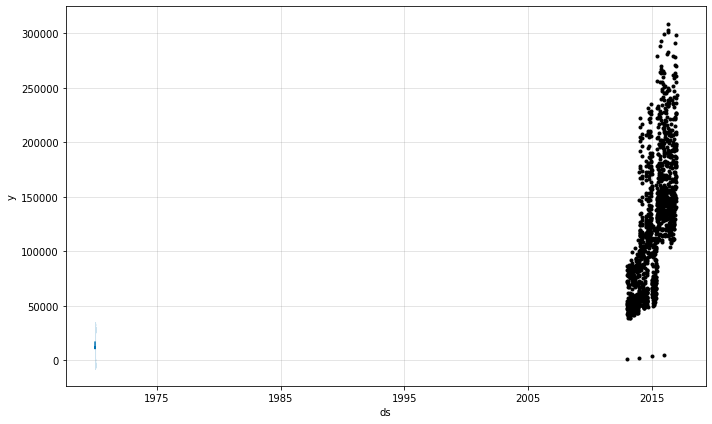

In [38]:
# Build-it plot
model.plot(forecast_test_week);

In [42]:
future_week = model_week.make_future_dataframe(periods=4, freq='MS')
forecast_future_week = model_week.predict(future) 
forecast_future_week.head()

/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/root/.pyenv/versions/3.8.12/envs/business_case_869/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


MemoryError: Unable to allocate 5.04 EiB for an array with shape (726964615660392704,) and data type float64

# Options to analyze

                 ds  store_nbr      family     y  onpromotion   city
0        2013-01-01          1  AUTOMOTIVE   0.0            0  Quito
33       2013-01-02          1  AUTOMOTIVE   2.0            0  Quito
66       2013-01-03          1  AUTOMOTIVE   3.0            0  Quito
99       2013-01-04          1  AUTOMOTIVE   3.0            0  Quito
132      2013-01-05          1  AUTOMOTIVE   5.0            0  Quito
...             ...        ...         ...   ...          ...    ...
3000723  2017-08-11          9  AUTOMOTIVE  18.0            0  Quito
3000756  2017-08-12          9  AUTOMOTIVE   8.0            0  Quito
3000789  2017-08-13          9  AUTOMOTIVE  15.0            0  Quito
3000822  2017-08-14          9  AUTOMOTIVE   8.0            0  Quito
3000855  2017-08-15          9  AUTOMOTIVE  15.0            0  Quito

[90936 rows x 6 columns]
                 ds  store_nbr     family    y  onpromotion   city
1        2013-01-01          1  BABY CARE  0.0            0  Quito
34       201

                 ds  store_nbr     family         y  onpromotion   city
12       2013-01-01          1  GROCERY I     0.000            0  Quito
45       2013-01-02          1  GROCERY I  2652.000            0  Quito
78       2013-01-03          1  GROCERY I  2121.000            0  Quito
111      2013-01-04          1  GROCERY I  2056.000            0  Quito
144      2013-01-05          1  GROCERY I  2216.000            0  Quito
...             ...        ...        ...       ...          ...    ...
3000735  2017-08-11          9  GROCERY I  5882.578           65  Quito
3000768  2017-08-12          9  GROCERY I  6686.109           64  Quito
3000801  2017-08-13          9  GROCERY I  6711.156           62  Quito
3000834  2017-08-14          9  GROCERY I  5860.789           58  Quito
3000867  2017-08-15          9  GROCERY I  6630.383           62  Quito

[90936 rows x 6 columns]
                 ds  store_nbr      family     y  onpromotion   city
13       2013-01-01          1  GROCERY I

                 ds  store_nbr family        y  onpromotion   city
24       2013-01-01          1  MEATS    0.000            0  Quito
57       2013-01-02          1  MEATS  369.101            0  Quito
90       2013-01-03          1  MEATS  272.319            0  Quito
123      2013-01-04          1  MEATS  454.172            0  Quito
156      2013-01-05          1  MEATS  328.940            0  Quito
...             ...        ...    ...      ...          ...    ...
3000747  2017-08-11          9  MEATS  309.245            0  Quito
3000780  2017-08-12          9  MEATS  260.298            0  Quito
3000813  2017-08-13          9  MEATS  327.206            0  Quito
3000846  2017-08-14          9  MEATS  330.975            0  Quito
3000879  2017-08-15          9  MEATS  449.228            0  Quito

[90936 rows x 6 columns]
                 ds  store_nbr         family      y  onpromotion   city
25       2013-01-01          1  PERSONAL CARE    0.0            0  Quito
58       2013-01-02     

In [ ]:
Option 1 = diferença % de familia por storage (prever família) 33 modelos
Option 2 = 

In [ ]:
54*33

In [ ]:
54*33*(365*4)


In [ ]:
RNN? Como sequenciar? melhor pra long term
Sequencia de storage+familia (sales total)
Input = sales + store_nbr + family
